## Problem Statment 
HElP ngo have raised fund of around $10million and they want to divide this fund to stratetically and effectivety to the country who are in need of the money. This is an attempt to categorise the countries based on health, finance and Trade using unsupervised machine learning clustering algorithm.
This dataset is taken form kaggal.

In [40]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import parallel_coordinates

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn import preprocessing
from sklearn.metrics import pairwise

import plotly.express as px
!pip install -U kaleido
import kaleido

In [41]:
data = pd.read_csv("Country-data.csv")
data

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200
...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310


In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [43]:
data.isnull().any()

country       False
child_mort    False
exports       False
health        False
imports       False
income        False
inflation     False
life_expec    False
total_fer     False
gdpp          False
dtype: bool

In [44]:
data.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


### Division of feature 
For the ease of graphical data analysis, divided the data into two category one with all the numercial features and other one with the string datatype.

In [45]:
col = list(data.columns)
col.remove('country')
categorical_features = ['country']
numerical_features = [*col]
print('Categorical Features :',*categorical_features)
print('Numerical Features :',*numerical_features)

Categorical Features : country
Numerical Features : child_mort exports health imports income inflation life_expec total_fer gdpp


### Histogram Analysis
life_expec is the only which is left or negatively skewed data.
Health is normally distributed.
All the data is right or positively skewed data.

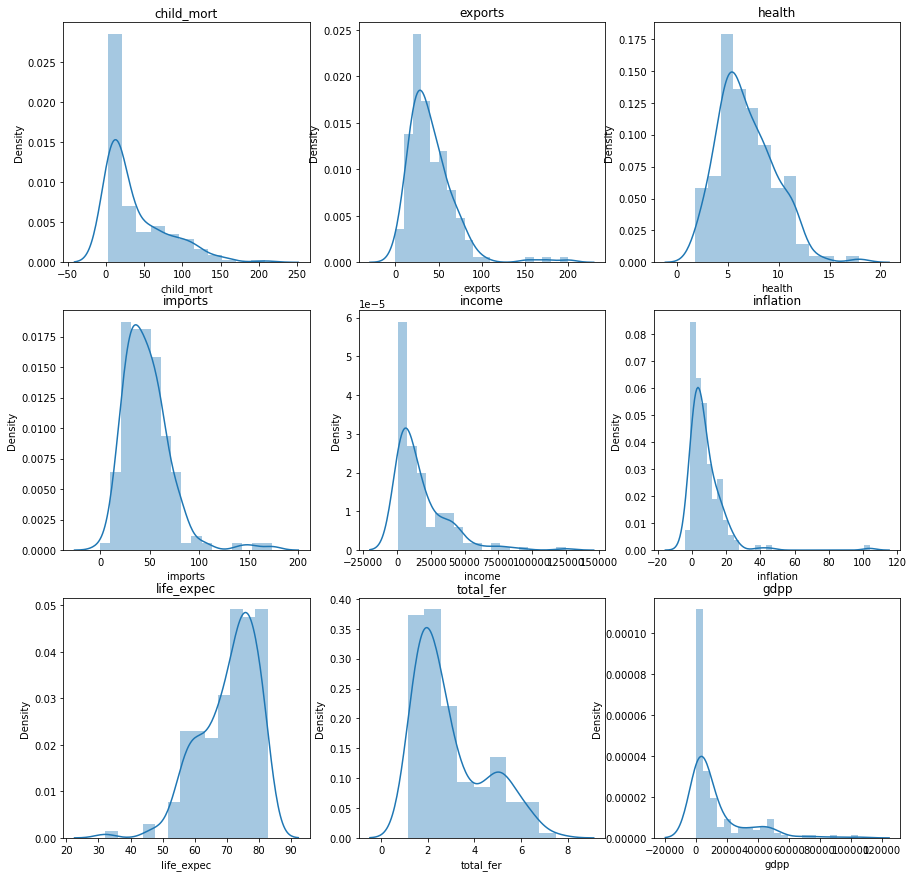

In [46]:
fig, ax = plt.subplots(nrows = 3,ncols = 3,figsize = (15,15))
for i in range(len(numerical_features)):
    plt.subplot(3,3,i+1)
    sns.distplot(data[numerical_features[i]])
    title = numerical_features[i]
    plt.title(title)
plt.show()

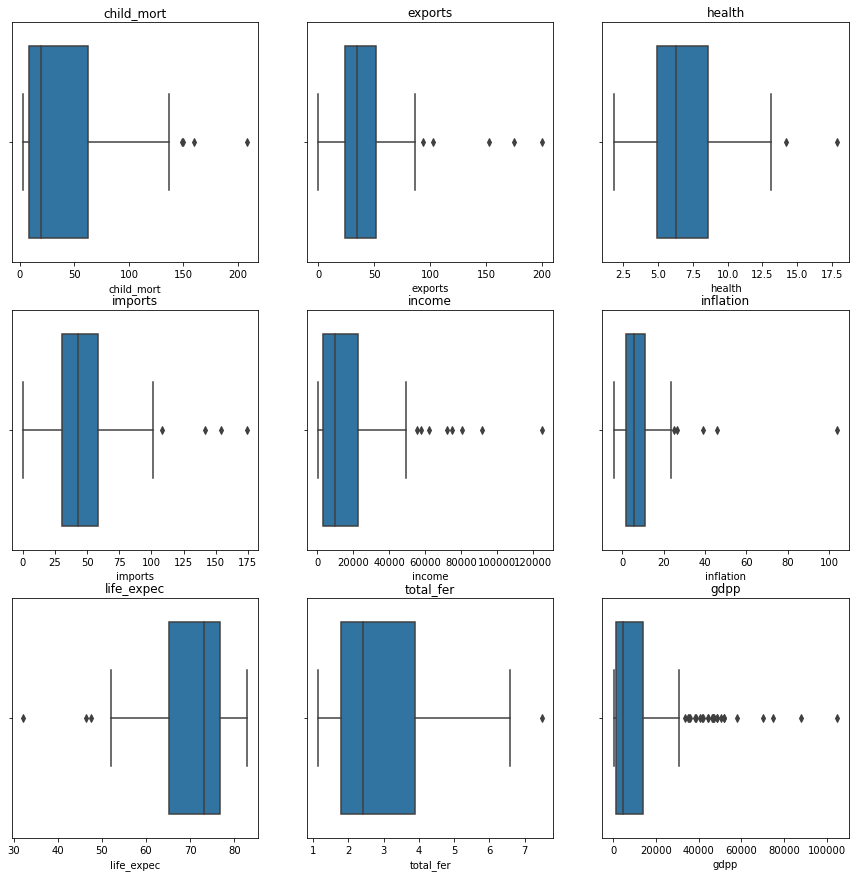

In [47]:
fig  = plt.subplots(nrows = 3,ncols = 3,figsize = (15,15))
for i in range(len(numerical_features)):
    plt.subplot(3,3,i+1)
    ax = sns.boxplot(data[numerical_features[i]])
    plt.title(numerical_features[i])
plt.show()

### Correlation Matrix
- Based on the heatmap, there are many feature which have relationships with each other.
- Health is slightly related to life_expec and decreases the child_mort.
- Rise in exports clearly increases gdpp, income & imports.
- income & gdpp display a very high 0.9 correlation value.
As some features have same reaction, let's club them together for the easier analysis purpose.



<AxesSubplot:>

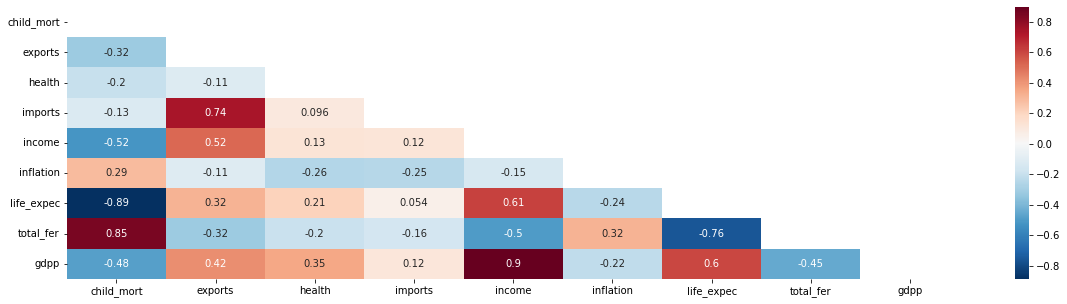

In [48]:
mask = np.zeros_like(data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(20,5))
sns.heatmap(data.corr(),cmap='RdBu_r',mask=mask, annot=True)

### Data Scaling

In [49]:
df1 = pd.DataFrame()
df1['Health'] = (data['child_mort'] / data['child_mort'].mean()) + (data['health'] / data['health'].mean()) + (data['life_expec'] / data['life_expec'].mean()) + (data['total_fer'] / data['total_fer'].mean())
df1['Trade'] = (data['imports'] / data['imports'].mean()) + (data['exports'] / data['exports'].mean())
df1['Finance'] = (data['income'] / data['income'].mean()) + (data['inflation'] / data['inflation'].mean()) + (data['gdpp'] / data['gdpp'].mean())
df1.head()

,Health,Trade,Finance
0,6.239852,1.200812,1.349645
1,3.035901,1.717580,1.471658
2,3.389763,1.603752,3.165367
3,6.469020,2.430387,3.494919
4,2.964898,2.362940,2.240150


### Normalization 
As conluded from the histograms, except health which is normally distributed other data shows skewness. Before training algorithm it is recommended to normalize the dataset.

In [50]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
mms = MinMaxScaler() # Normalization
ss = StandardScaler() # Standardization

df1['Health'] = mms.fit_transform(df1[['Health']])
df1['Trade'] = mms.fit_transform(df1[['Trade']])
df1['Finance'] = mms.fit_transform(df1[['Finance']])
df1.insert(loc = 0, value = list(data['country']), column = 'Country')
df1.head()

,Country,Health,Trade,Finance
0,Afghanistan,0.625740,0.139614,0.079820
1,Albania,0.127451,0.199901,0.088756
2,Algeria,0.182485,0.186622,0.212808
3,Angola,0.661381,0.283058,0.236946
4,Antigua and Barbuda,0.116409,0.275189,0.145043


### Principal Component Analysis(PCA)
Based on the analysis after applying PCA to the dataset and calculating the variance covered by eigen values, value - 2 is enough of covering more than 95% of the variance.

In [51]:
df2 = data.copy(deep = True)

col = list(data.columns)
col.remove('health'); col.remove('country')

df2['health'] = ss.fit_transform(df2[['health']]) # Standardization

for i in col:
    df2[i] = mms.fit_transform(df2[[i]]) # Normalization
df2.drop(columns = 'country',inplace = True) 
df2.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.426485,0.049482,0.279088,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073
1,0.068160,0.139531,-0.097016,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833
2,0.120253,0.191559,-0.966073,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365
3,0.566699,0.311125,-1.448071,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488
4,0.037488,0.227079,-0.286894,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242


In [52]:
from sklearn.decomposition import PCA

pca = PCA()
pca_df2 = pd.DataFrame(pca.fit_transform(df2))
pca.explained_variance_

array([1.01740511, 0.13090418, 0.03450018, 0.02679822, 0.00979752,
       0.00803398, 0.00307055, 0.00239976, 0.00179388])

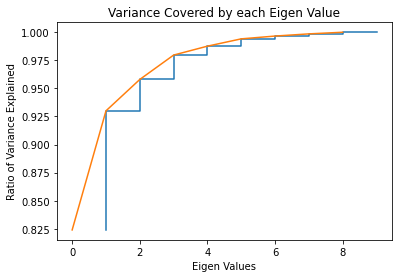

In [53]:
plt.step(list(range(1,10)), np.cumsum(pca.explained_variance_ratio_))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Eigen Values')
plt.ylabel('Ratio of Variance Explained')
plt.title('Variance Covered by each Eigen Value')
plt.show()

In [54]:
pca_df2 = pca_df2.drop(columns = [3,4,5,6,7,8])
pca_df2.head()

,0,1,2
0,0.220482,0.640048,0.086112
1,-0.080903,-0.172000,-0.208695
2,-0.961283,-0.125199,-0.126719
3,-1.505914,0.472144,0.284978
4,-0.264724,-0.237308,-0.059150


### K-means Clustering

In [55]:
m1 = df1.drop(columns = ['Country']).values # Feature Combination : Health - Trade - Finance
m2 = pca_df2.values # PCA Data

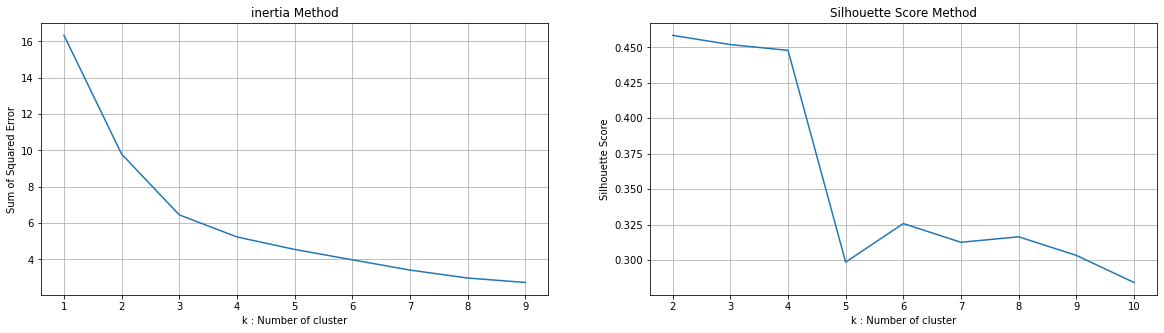

In [56]:
sse = {};sil = [];kmax = 10
fig = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

# inertia Method :
plt.subplot(1,2,1)
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(m1)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
sns.lineplot(x = list(sse.keys()), y = list(sse.values()));
plt.title('inertia Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Sum of Squared Error")
plt.grid()

# Silhouette Score Method
plt.subplot(1,2,2)
for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters = k).fit(m1)
    labels = kmeans.labels_
    sil.append(silhouette_score(m1, labels, metric = 'euclidean'))
sns.lineplot(x = range(2,kmax + 1), y = sil);
plt.title('Silhouette Score Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Silhouette Score")
plt.grid()

plt.show()

### Inertia Method & Silhouette Score Method
Based on the above graph, taking number of clusters as 3 is recommendable.

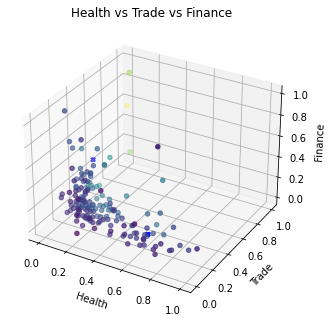

In [57]:
model = KMeans(n_clusters = 3,max_iter = 1000)
model.fit(m1)
cluster = model.cluster_centers_
centroids = np.array(cluster)
labels = model.labels_
data['Class'] = labels; df1['Class'] = labels

fig = plt.figure()
ax = Axes3D(fig)
x = np.array(df1['Health'])
y = np.array(df1['Trade'])
z = np.array(df1['Finance'])
ax.scatter(centroids[:,0],centroids[:,1],centroids[:,2],marker="X", color = 'b')
ax.scatter(x,y,z,c = y)
plt.title('Health vs Trade vs Finance')
ax.set_xlabel('Health')
ax.set_ylabel('Trade')
ax.set_zlabel('Finance')
plt.show();

### BoxPlot Analysis
- comparing the boxplot of income & child_mort w.r.t labelled clusters!
- We know that low income and high child mortality is a sign of an economically backward nation.

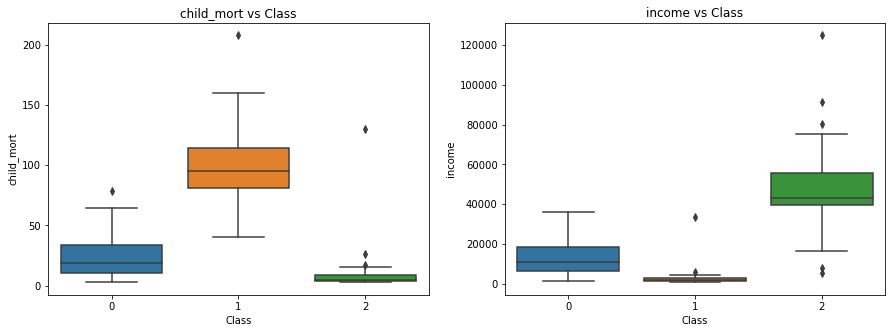

In [58]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

plt.subplot(1,2,1)
sns.boxplot(x = 'Class', y = 'child_mort', data  = data);
plt.title('child_mort vs Class')

plt.subplot(1,2,2)
sns.boxplot(x = 'Class', y = 'income', data  = data);
plt.title('income vs Class')

plt.show()

From the above plot we can conclude :
0 : No Help Needed
1 : Help Needed
2 : Might Need Help

In [65]:
df1['Class'].loc[df1['Class'] == 0] = 'No Help Needed'
df1['Class'].loc[df1['Class'] == 1] = 'Help Needed'
df1['Class'].loc[df1['Class'] == 2] = 'Might Need Help'

fig = px.choropleth(df1[['Country','Class']],
                    locationmode = 'country names',
                    locations = 'Country',
                    title = 'Needed Help Per Country (World)',
                    color = df1['Class'],  
                    color_discrete_map = {'Help Needed':'Red',
                                        'No Help Needed':'Green',
                                        'Might Need Help':'Yellow'}
                   )
fig.update_geos(fitbounds = "locations", visible = True)
fig.update_layout(legend_title_text = 'Labels',legend_title_side = 'top',title_pad_l = 260,title_y = 0.86)
fig.show(engine = 'kaleido')

### PCA Data

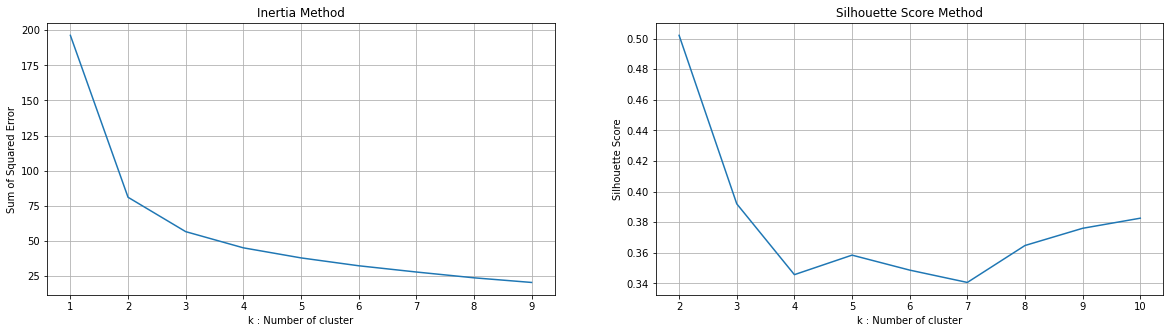

In [66]:
sse = {};sil = [];kmax = 10
fig = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

# Inertia Method :
plt.subplot(1,2,1)
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(m2)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
sns.lineplot(x = list(sse.keys()), y = list(sse.values()));
plt.title('Inertia Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Sum of Squared Error")
plt.grid()

# Silhouette Score Method
plt.subplot(1,2,2)
for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters = k).fit(m2)
    labels = kmeans.labels_
    sil.append(silhouette_score(m2, labels, metric = 'euclidean'))
sns.lineplot(x = range(2,kmax + 1), y = sil);
plt.title('Silhouette Score Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Silhouette Score")
plt.grid()

plt.show()

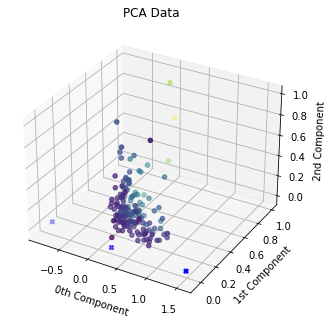

In [67]:
model = KMeans(n_clusters = 3,max_iter = 1000)
model.fit(m2)
cluster = model.cluster_centers_
centroids = np.array(cluster)
labels = model.labels_
data['Class'] = labels; pca_df2['Class'] = labels

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(centroids[:,0],centroids[:,1],centroids[:,2],marker="X", color = 'b')
plt.title('PCA Data')
ax.set_xlabel('0th Component')
ax.set_ylabel('1st Component')
ax.set_zlabel('2nd Component')
ax.scatter(x,y,z,c = y)
plt.show();

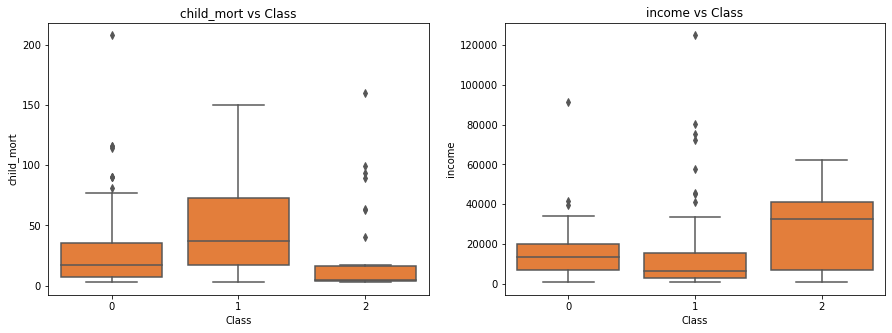

In [68]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

plt.subplot(1,2,1)
sns.boxplot(x = 'Class', y = 'child_mort', data  = data, color = '#FF781F');
plt.title('child_mort vs Class')

plt.subplot(1,2,2)
sns.boxplot(x = 'Class', y = 'income', data  = data, color = '#FF781F');
plt.title('income vs Class')

plt.show()

In [69]:
pca_df2.insert(0,column = 'Country', value = data['country'])

pca_df2['Class'].loc[pca_df2['Class'] == 0] = 'Might Need Help'
pca_df2['Class'].loc[pca_df2['Class'] == 1] = 'Help Needed'
pca_df2['Class'].loc[pca_df2['Class'] == 2] = 'No Help Needed'

fig = px.choropleth(pca_df2[['Country','Class']],
                    locationmode = 'country names',
                    locations = 'Country',
                    title = 'Needed Help Per Country (World)',
                    color = pca_df2['Class'],  
                    color_discrete_map = {'Help Needed':'Red',
                                          'Might Need Help':'Yellow',
                                          'No Help Needed': 'Green'})
fig.update_geos(fitbounds = "locations", visible = True)
fig.update_layout(legend_title_text = 'Labels',legend_title_side = 'top',title_pad_l = 260,title_y = 0.86)
fig.show(engine = 'kaleido')

### Hierarchical Clustering
- In this case, we need to divide the countries into 3 categories. That is why we will select a 3 clusters directly. Dendrogram analysis for this dataset is kind of redundant.
- Here, we can see that 1 blue line alongwith 2 red lines are the penultimate clusters that before connecting together.
- It has 3 branches, thus indicating the 3 clusters that it creates before merging into 1!

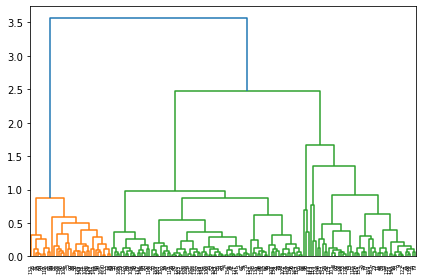

In [60]:
linkage_data = linkage(m1, method = 'ward', metric = 'euclidean')
dendrogram(linkage_data)
plt.tight_layout()
plt.show()

In [61]:
from sklearn.cluster import AgglomerativeClustering
hierarchical_cluster = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
labels = hierarchical_cluster.fit(m1)

pred_agc = pd.Series(hierarchical_cluster.labels_)
data['Class'] = pred_agc; df1['Class'] = pred_agc

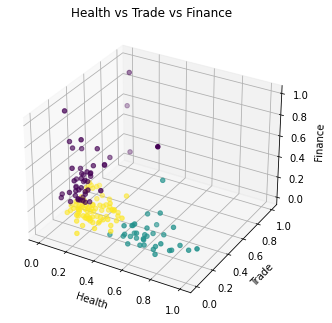

In [62]:
fig = plt.figure()
ax = Axes3D(fig)
x = np.array(df1['Health'])
y = np.array(df1['Trade'])
z = np.array(df1['Finance'])
ax.scatter(x,y,z,c = df1['Class'])
plt.title('Health vs Trade vs Finance')
ax.set_xlabel('Health')
ax.set_ylabel('Trade')
ax.set_zlabel('Finance')
plt.show();

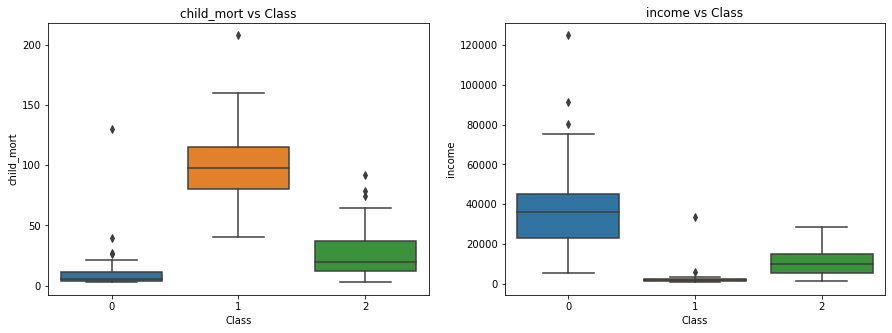

In [63]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

plt.subplot(1,2,1)
sns.boxplot(x = 'Class', y = 'child_mort', data  = data);
plt.title('child_mort vs Class')

plt.subplot(1,2,2)
sns.boxplot(x = 'Class', y = 'income', data  = data);
plt.title('income vs Class')

plt.show()

In [64]:
df1['Class'].loc[df1['Class'] == 0] = 'No Help Needed'
df1['Class'].loc[df1['Class'] == 1] = 'Help Needed'
df1['Class'].loc[df1['Class'] == 2] = 'Might Need Help'

fig = px.choropleth(df1[['Country','Class']],
                    locationmode = 'country names',
                    locations = 'Country',
                    title = 'Needed Help Per Country (World)',
                    color = df1['Class'],  
                    color_discrete_map = {'Help Needed' : 'Red',
                                          'Might Need Help' : 'Yellow',
                                          'No Help Needed' : 'Green'})
fig.update_geos(fitbounds = "locations", visible = True)
fig.update_layout(legend_title_text = 'Labels',legend_title_side = 'top',title_pad_l = 260,title_y = 0.86)
fig.show(engine = 'kaleido')

### Conclusion
- Explanatory Data analysis provide a good insights based on that we were able to identify that data is not normalized and there is a need of normalization and standardization on the dataset.
- HeatMap concluded that there are many feature which are related to each other so they can be combined for better analysis. Here, I have categorized the data into major 3 category health, trade and finance.
- After getting data ready for model, I have implement k-means and Hierarchical Clustering, results of both the model are quite similar.
- From the interia and Silhouette Score Method, dividing the data into 3 clusters is recommendable.
- Then, genrated 3 categories 0:No help needed, 1:Might Need help, 2:Help Needed.
- The countries which need help using K-means Clustering Analysis are:
    1. Afghanistan 
    2. Some of the African countries
- No help Needed countries are:
    1. USA 
    2. Russia
    3. Australia
    4. Canada
    5. Few european countries
- Might Need help
    1. Some of the south American countries
    2. Some of the Asian Countries